In [35]:
import tensorflow as tf
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_data_dir = "./data/datasets/train/"
validation_data_dir = "./data/datasets/validation/"
batch_size = 16
epochs = 25

In [11]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode="binary")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(150, 150),
                                                        batch_size=batch_size,
                                                        class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 998 images belonging to 2 classes.


In [12]:
# from tensorflow.keras.models import load_model

# model = load_model("./data/models/cats_vs_dogs_V1.h5")
# model.summary()

In [14]:
# loader function
def load_training_and_test_data(datasetName):
    
    npzfile = np.load("./data/datasets/" + datasetName + "_training_data.npz")
    train = npzfile["arr_0"]
    
    npzfile = np.load("./data/datasets/" + datasetName + "_training_labels.npz")
    train_labels = npzfile["arr_0"]
    
    npzfile = np.load("./data/datasets/" + datasetName + "_test_data.npz")
    test = npzfile["arr_0"]
    
    npzfile = np.load("./data/datasets/" + datasetName + "_test_labels.npz")
    test_labels = npzfile["arr_0"]
    
    return (train, train_labels), (test, test_labels)

In [15]:
(X_train, y_train), (X_test, y_test) = load_training_and_test_data("cats_vs_dogs")

In [20]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)

In [16]:
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation="relu")(i)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [22]:
%%time

model.fit(train_generator,
          steps_per_epoch=nb_train_samples//batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=nb_validation_samples//batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 62 steps
Epoch 1/25
125/125 [==============================] - 152s 1s/step - loss: 0.6701 - accuracy: 0.6215 - val_loss: 0.6265 - val_accuracy: 0.6724
Epoch 2/25
125/125 [==============================] - 128s 1s/step - loss: 0.6449 - accuracy: 0.6365 - val_loss: 0.6156 - val_accuracy: 0.6603
Epoch 3/25
125/125 [==============================] - 120s 964ms/step - loss: 0.6180 - accuracy: 0.6590 - val_loss: 0.5957 - val_accuracy: 0.6865
Epoch 4/25
125/125 [==============================] - 109s 872ms/step - loss: 0.6105 - accuracy: 0.6770 - val_loss: 0.5724 - val_accuracy: 0.7097
Epoch 5/25
125/125 [==============================] - 113s 907ms/step - loss: 0.5728 - accuracy: 0.7080 - val_loss: 0.7747 - val_accuracy: 0.5756
Epoch 6/25
125/125 [==============================] - 130s 1s/step - loss: 0.5619 - accuracy: 0.7220 - val_loss: 0.5522 - val_accuracy: 0.7268
Epoch 7/25
125/125 [====================

In [26]:
r = model.history

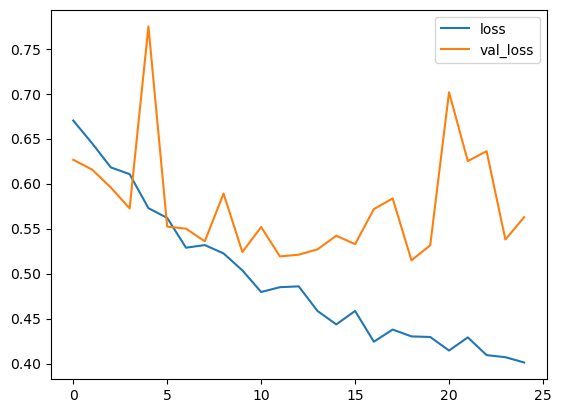

In [27]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend();

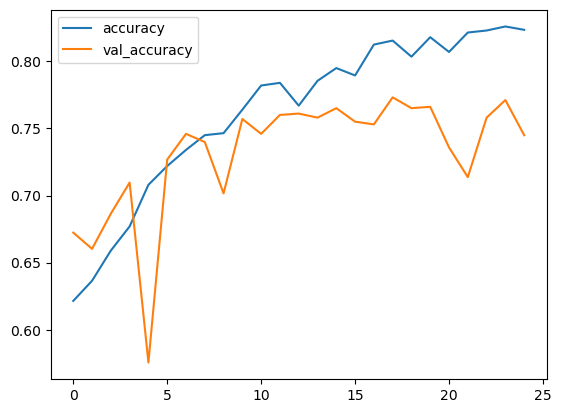

In [28]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend();

In [29]:
# augmented
model.save("./data/models/cats_vs_dogs_V2.h5")

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
y_pred = model.predict(X_test)

In [33]:
print(classification_report(y_test, np.rint(y_pred)))

              precision    recall  f1-score   support

           0       0.75      0.58      0.65       499
           1       0.66      0.81      0.73       499

    accuracy                           0.69       998
   macro avg       0.70      0.69      0.69       998
weighted avg       0.70      0.69      0.69       998



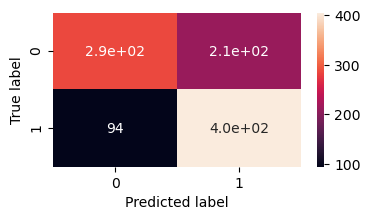

In [38]:
fig, ax = plt.subplots(figsize = (4, 2))

cm = confusion_matrix(y_test, np.rint(y_pred))
ax = sns.heatmap(cm, annot = True)
ax.set(xlabel="Predicted label", ylabel="True label");

**observation: from `classification report` and `confusion matrix`**

- for class-0(Cat), high precision and low recall
    - Our classifier is missing a lot of positive examples(high FN = 210)
    - but those we predict as positive are indeed positive (low FP = 94)
- for class-1(Dog), low precision and high recall
    - This tells us that most of the positive examples are correctly recognized (low FN = 94)
    - but there are lot of FP(210) as Cat class is being predicted as Dog class